In [1]:
from competition_modeling import *
from sklearn import model_selection
from matplotlib import colors as mcolors
import seaborn as sns
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
cd /Users/fernandes/Dropbox (Personal)/Github_Migas/Behavior data for github

/Users/fernandes/Dropbox (Personal)/Github_Migas/Behavior data for github


In [3]:
ls

Competition_MF270_MF293/
Competition_model_WTA_Averaging/
MF270_MF296_together_binocular_competition/
MF319_competition_3_conditions/
PositionTxt_allROI2019-10-07T09_49_19.txt*
PositionTxt_allROI2019-10-07T09_49_19.txt.zip


# Load all csv files for all conditions

In [4]:
datadir = r"Competition_model_WTA_Averaging"
csvs = [f for f in os.listdir(datadir) if f.endswith(".csv")]

all_radians = {}
for csv in csvs:
    print (csv)
    csvpath = os.path.join(datadir, csv)
    df = pd.read_csv(csvpath, index_col=0)

    x = df['x'].dropna().values
    y = df['y'].dropna().values
    condition = int(os.path.splitext(csv)[0][-1])
    radians = (-np.arctan2(y, x) - np.pi / 2) % (2 * np.pi)
    all_radians[condition] = radians

datarange = (0, 2 * np.pi)
condition_names = ["small_left", "big_right", "small_left_&_big_right",
                   "small_right", "big_left", "big_left_&_small_right",
                   "small_left_&_small_right", "big_left_&_big_right"]

condition_sets = [[0, 3, 6], [4, 1, 7], [0, 1, 2], [4, 3, 5]]  # defining sets of s1, s2, both  -  s1 is always left

compname = 'WTA'

compcolor = 'blue'
avgcolor = 'red'
mixcolor = 'purple'
mix2color = 'orange'
bothcolor = 'black'


MF270_MF296_together_binocular_competitioncondition_2.csv
MF270_MF296_together_binocular_competitioncondition_3.csv
MF270_MF296_together_binocular_competitioncondition_1.csv
MF270_MF296_together_binocular_competitioncondition_0.csv
MF270_MF296_together_binocular_competitioncondition_4.csv
MF270_MF296_together_binocular_competitioncondition_5.csv
MF270_MF296_together_binocular_competitioncondition_7.csv
MF270_MF296_together_binocular_competitioncondition_6.csv


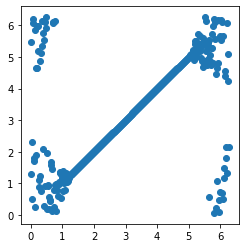

In [5]:
def shuffle_backwards(radians_in, scale=1, width=0.3):
    """Reduces the prevalence of backwards bouts, by adding extra random deviations to them"""
    # assuming input is 0 to 2*pi
    #scale 0 to inf
    #width 0 to 1
    r= np.random.uniform(size=radians_in.shape) - .5
    exp = (np.pi-np.minimum(radians_in, 2*np.pi-radians_in))/np.pi
    newx = np.maximum(exp-(1-width), np.zeros_like(exp))/width*scale
    r *= newx
    radians_out = radians_in + r
    return radians_out % (2 * np.pi)


plt.figure()
xs = np.linspace(0, 2*np.pi, 400, endpoint=False)
ax = plt.scatter(xs, shuffle_backwards(xs, 5, .4))
plt.gca().set_aspect('equal', 'box')

In [6]:
def avg_model_back(*args):
    """Mix model wrapper, with a reshuffling of backwards results"""
    return shuffle_backwards(avg_model(*args), 2, .9)

def mix_model_back(*args):
    """Mix model wrapper, with a reshuffling of backwards results"""
    return shuffle_backwards(mix_model(*args), 2, .9)

def mix_model_bias_back(*args):
    """Mix model wrapper, with a reshuffling of backwards results"""
    return shuffle_backwards(mix_model_bias(*args), 2, .9)

'''the 2 arg is the scale (amount of reshuffling, higher is more)\
and the .9 arg is the width (0 to 1, with closer to zero meaning only straight. Back gets reshuffled)'''

'the 2 arg is the scale (amount of reshuffling, higher is more)and the .9 arg is the width (0 to 1, with closer to zero meaning only straight. Back gets reshuffled)'

# Setup for crossval

In [7]:
'''Random permutation cross-validator

Yields indices to split data into training and test sets.
see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html'''

splitter = model_selection.ShuffleSplit(n_splits=1, test_size=.2, random_state=0)
def gettesttrain(data):
    return [data[idx] for idx in [s for s in splitter.split(data)][0]]


In [8]:
condition_sets

[[0, 3, 6], [4, 1, 7], [0, 1, 2], [4, 3, 5]]

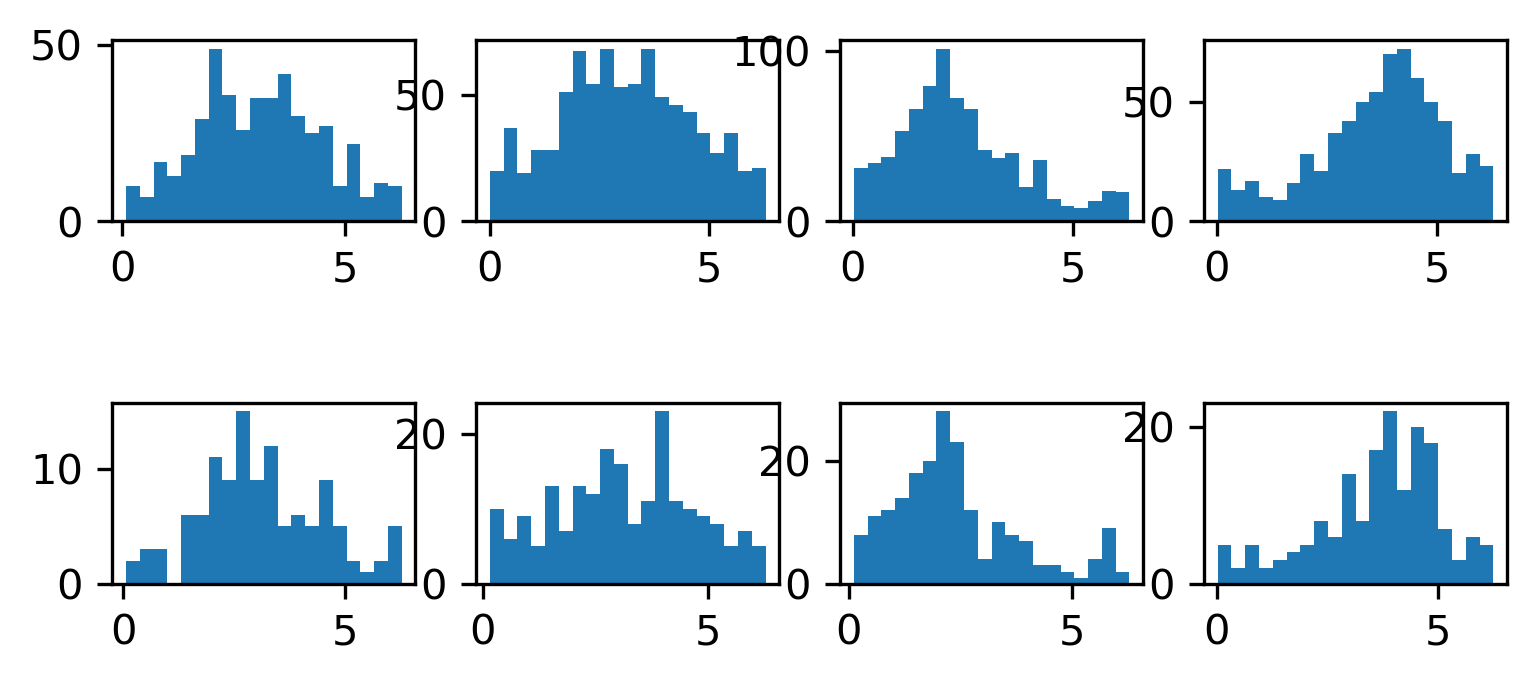

In [9]:
plt.figure(dpi=300)
gs = gridspec.GridSpec(3, len(condition_sets), hspace=1)
for i, cs in enumerate(condition_sets):
    s1, s2, both_all = [all_radians[c] for c in cs]
    both_train, both_test = gettesttrain(both_all)  #for cross validation
    plt.subplot(gs[0, i])
    plt.hist(both_train, 20)
    plt.subplot(gs[1, i])
    plt.hist(both_test, 20)


# Plot of simple mixing model parameters
This model simply mixes both averaging and WTA models. No bias parameter is implemented for equal stimuli condition

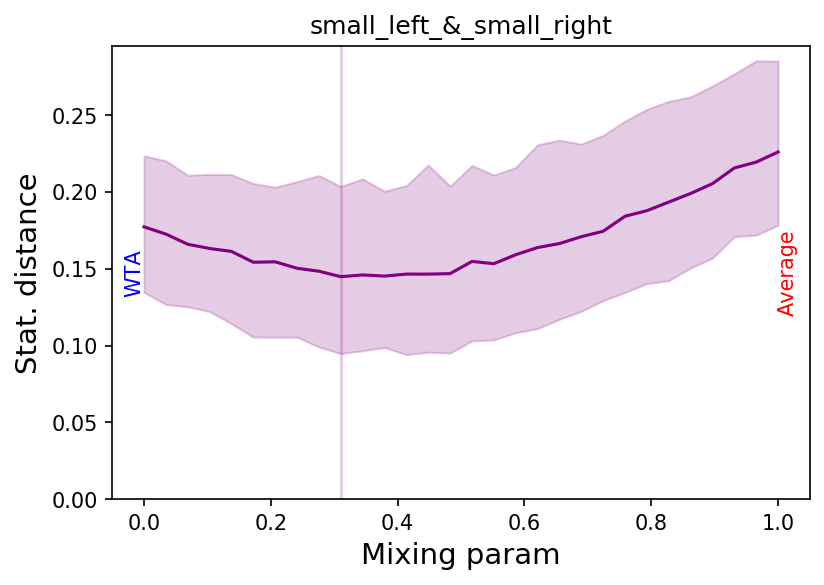

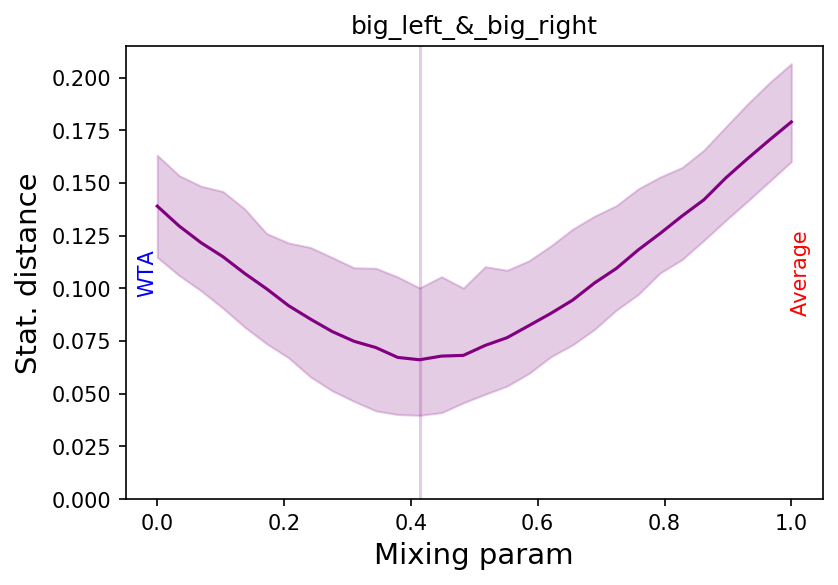

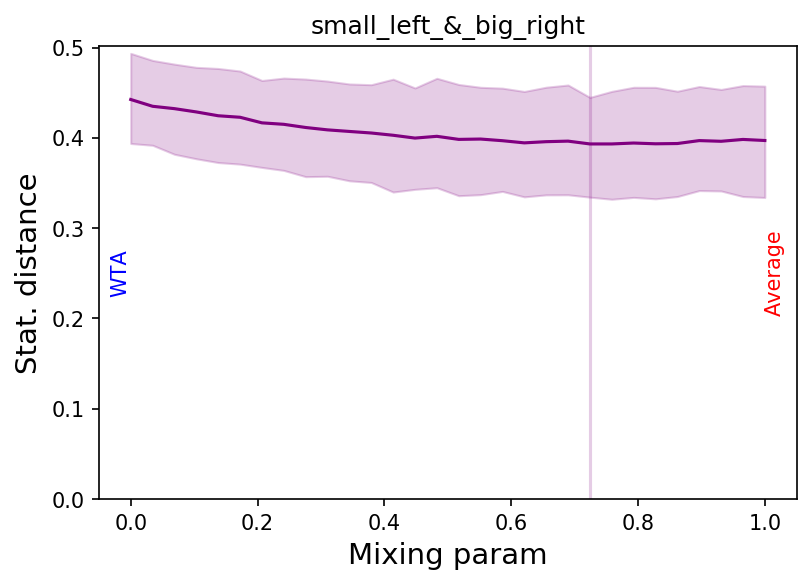

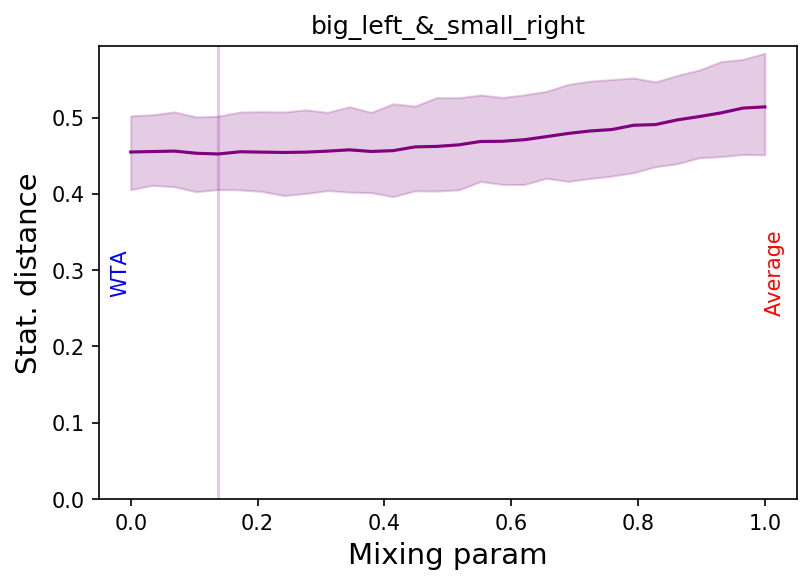

In [10]:
best_simple_mix = []
for cs in condition_sets:
    s1, s2, both_all = [all_radians[c] for c in cs]
    both_train, both_test = gettesttrain(both_all)  #for cross validation
    plt.figure(dpi=150)
    mixes = np.linspace(0, 1, 30)

    stat_dists = np.vstack([[circ_energy_distance_fast(mix_model(s1, s2, both_train, m), both_train) for m in mixes] for i in range(500)]).T

    # stat_dists is npoints by nreps
    meanstat = stat_dists.mean(axis=1)
    #print('Best mix {}'.format(meanstat))
    plt.plot(mixes, meanstat, color=mixcolor)
    plt.axvline(mixes[meanstat.argmin()], color=mixcolor, alpha=.2)
    best_simple_mix.append(mixes[meanstat.argmin()])
    plt.fill_between(mixes, np.percentile(stat_dists, 2.5, 1), np.percentile(stat_dists, 97.5, 1), alpha=.2, color=mixcolor)

    plt.xlabel('Mixing param', fontsize=14)
    plt.ylabel('Stat. distance', fontsize=14)
    plt.annotate('WTA', (0.0, .5), xycoords=('data', 'axes fraction'), rotation=90, ha='right', va='center', color=compcolor)
    plt.annotate('Average', (1.0, .5), xycoords=('data', 'axes fraction'), rotation=90, va='center', color=avgcolor)
    plt.title(condition_names[cs[-1]])
    plt.gca().set_ylim(bottom=0)
    #plt.savefig('model_figure_export\\'+'simple_mixratio{}.svg'.format(condition_names[cs[-1]]), dpi=300)
plt.show()

In [11]:
best_simple_mix

[0.3103448275862069,
 0.41379310344827586,
 0.7241379310344828,
 0.13793103448275862]

# Plot KDE grid

In [12]:
def plot_kdes(data, condition_idxs):
        s1, s2, both = [data[c] for c in condition_idxs]
        nreps = 200
        mix_p = best_simple_mix
        plot_names = [condition_names[condition_idxs[0]], condition_names[condition_idxs[1]], condition_names[condition_idxs[2]],
                      'WTA model', 'Average model', 'Mix model = {:.1f}'.format(mix_p[csnum])]
        kdedata = [s1, s2, both, np.vstack([comp_model(s1, s2, both) for i in range(nreps)]),
                   np.vstack([avg_model_back(s1, s2, both) for i in range(nreps)]),
                   np.vstack([mix_model_back(s1, s2, both, mix_p[csnum]) for i in range(nreps)]),
                   ]
        plotcolors = ['black', 'black', bothcolor, compcolor, avgcolor, mixcolor]
        multi_sample = [False, False, False, True, True, True]
        gs = gridspec.GridSpec(2, 3, hspace=1.2, wspace=.3)
        plt.figure(dpi=150)

        for axnum, name in enumerate(plot_names):
            ax = plt.subplot(gs[axnum])

            if multi_sample[axnum]:
                xs, kdes = zip(*[vonmises_kde(d, 30, 200) for d in kdedata[axnum]])
                kdes = np.vstack(kdes)
                plt.fill_between(xs[0], np.percentile(kdes, 2.5, 0), np.percentile(kdes, 97.5, 0), alpha=.2, color=plotcolors[axnum])
                plt.plot(xs[0], kdes.mean(0), color=plotcolors[axnum])

                plt.plot(*vonmises_kde(both, 30, 200), c=bothcolor, alpha=.8)
            else:
                x, kde = vonmises_kde(kdedata[axnum], 30, 200)
                plt.plot(x, kde, color=plotcolors[axnum])

            plt.title(name)
            plt.ylim((0, .55))
            if axnum % 3 == 0:
                plt.ylabel('Prob. density', fontsize=14)
            plt.xticks([np.pi / 2, np.pi, 3 * np.pi / 2], ['left', 'forward', 'right'], rotation=-35, ha='left', rotation_mode="anchor")
            plt.tick_params(labelleft=False, left=False)
        #plt.savefig('model_figure_export\\' + 'simple_mix_models.svg',dpi=300)


# Taking the lowest values (closest to real data) to plot KDE. 

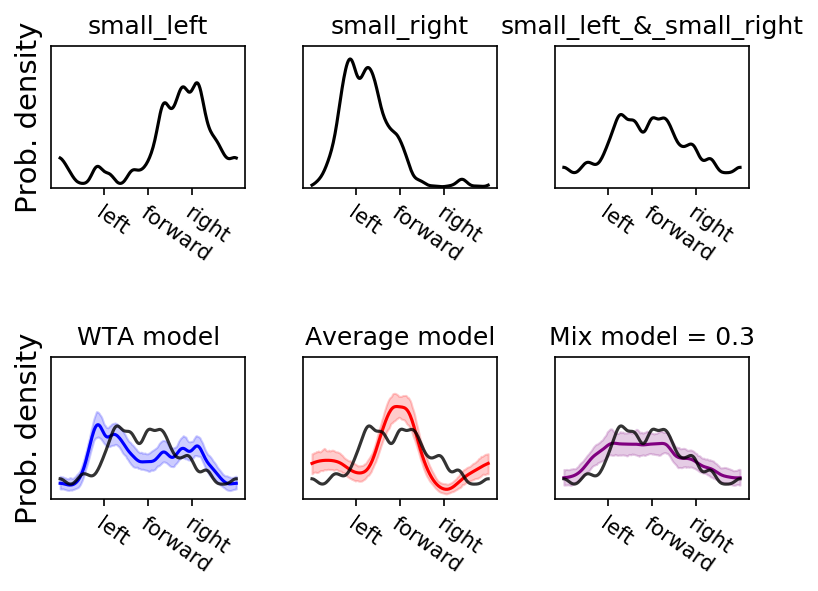

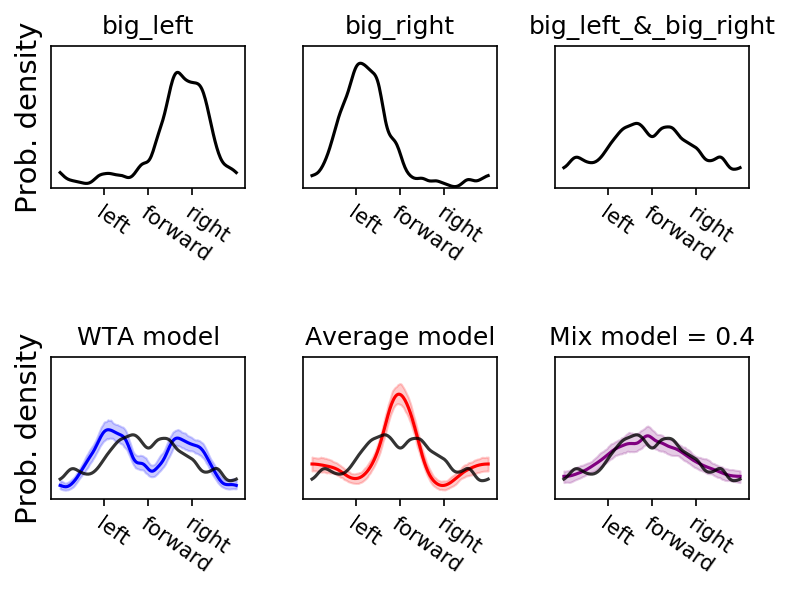

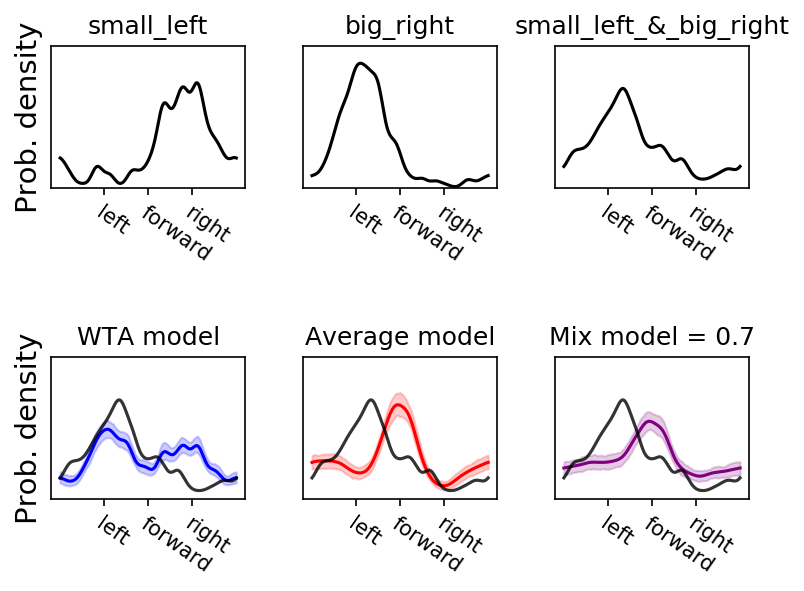

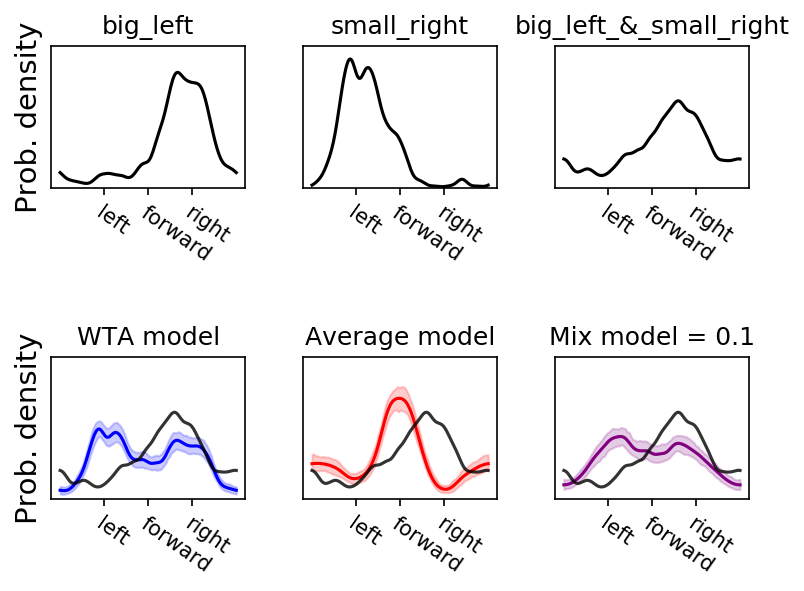

In [13]:
for csnum, cs in enumerate(condition_sets):
    plot_kdes(all_radians, cs)
    #plt.savefig('model_figure_export\\' +'simple_mix_models{}.svg'.format(condition_names[cs[-1]]), dpi=300)

# Find best biased simple mixture
Introduce Bias as parameter to model data for unequal stImuli conditions

In [14]:
nmixes = 10
nbiases = 10
mixes = np.linspace(0, 1, nmixes)
biases = np.linspace(0, 1, nbiases)
biasmix_result = np.zeros((len(condition_sets), nmixes, nbiases)) #make a grid to store results


for csnum, cs in enumerate(condition_sets):
    s1, s2, both_all = [all_radians[c] for c in cs]
    both_train, both_test = gettesttrain(both_all)  #for cross validation

    stat_dists = np.asarray([[[circ_energy_distance_fast(mix_model_bias(s1, s2, both_train, m, b), both_train) for i in range(100)]
                              for m in mixes]
                             for b in biases]).mean(axis=-1)
    biasmix_result[csnum, ...] = stat_dists


# Grid search for better fit
Energy distance is used as measure

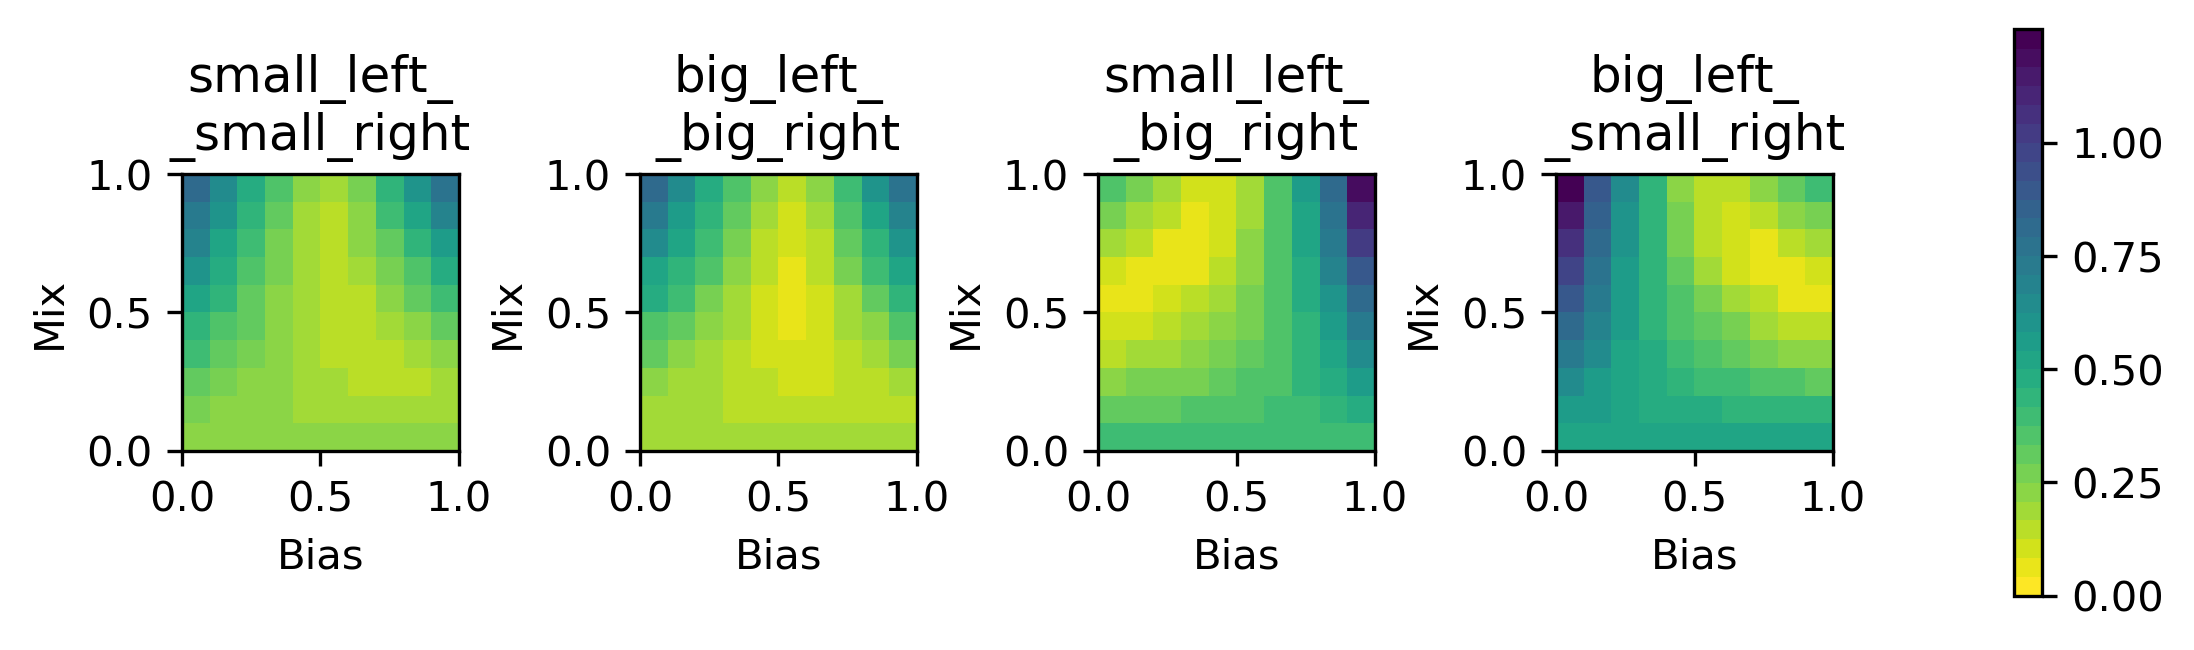

In [15]:
dpi=300
plt.figure(figsize=(8, 2.5), dpi=dpi)

vmax = biasmix_result.max()

gs = gridspec.GridSpec(1, len(condition_sets)+1, wspace=.8, width_ratios=([1,1,1,1,.1]),)    
for csnum, cs in enumerate(condition_sets):
    s1, s2, both_all = [all_radians[c] for c in cs]
    both_train, both_test = gettesttrain(both_all)  #for cross validation
    
    plt.subplot(gs[csnum])
    im = plt.imshow(biasmix_result[csnum].T[:,::-1], extent=(0, 1, 0, 1),
                    cmap=plt.cm.get_cmap('viridis_r',30), vmin=0, vmax=vmax,origin='upper')

    plt.ylabel('Mix')
    plt.xlabel('Bias')
    plt.title(condition_names[cs[-1]].replace('&', '\n'))
    
ax = plt.subplot(gs[-1])
cbar = plt.colorbar(im, cax=ax, ticks=np.linspace(0, 1, 5))


# We get broad regions with best values. There is no single best fit value but rather a broad range of values that give good results.

### Extract best params for each condition_set

In [16]:
best_biasmix_idx = [np.unravel_index(biasmix_result[csnum].argmin(), (nmixes, nbiases)) for csnum in range(len(condition_sets))]

'''If picking the best values by taking the lowest values'''
#best_biasmix_mixes = [mixes[best_idx[1]] for best_idx in best_biasmix_idx]
#best_biasmix_biases = [biases[best_idx[0]] for best_idx in best_biasmix_idx]

'''The result of finding the best fit leads to a broad range of possible outcomes. Variance is high.
We empirIcally determined the values that gives us the closest results to the real data'''
best_biasmix_mixes =[0.2,0.2,.2,0.2] #if changing manually mix to 0.2 for equal stim
best_biasmix_biases= [0.5,0.5,0.70,0.30] #if changing manually bias to 0.5 for equal stim

best_biasmix_params = list(zip(best_biasmix_mixes, best_biasmix_biases))
#extract closest mix to 0
best_compbias_biases = [biases[biasmix_result[csnum, :, 0].argmin()] for csnum in range(len(condition_sets))]



In [17]:
print(best_biasmix_mixes)
print(best_biasmix_biases)
print(best_compbias_biases)

[0.2, 0.2, 0.2, 0.2]
[0.5, 0.5, 0.7, 0.3]
[0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.3333333333333333]


# Plot KDE grid for biased simple mixtures

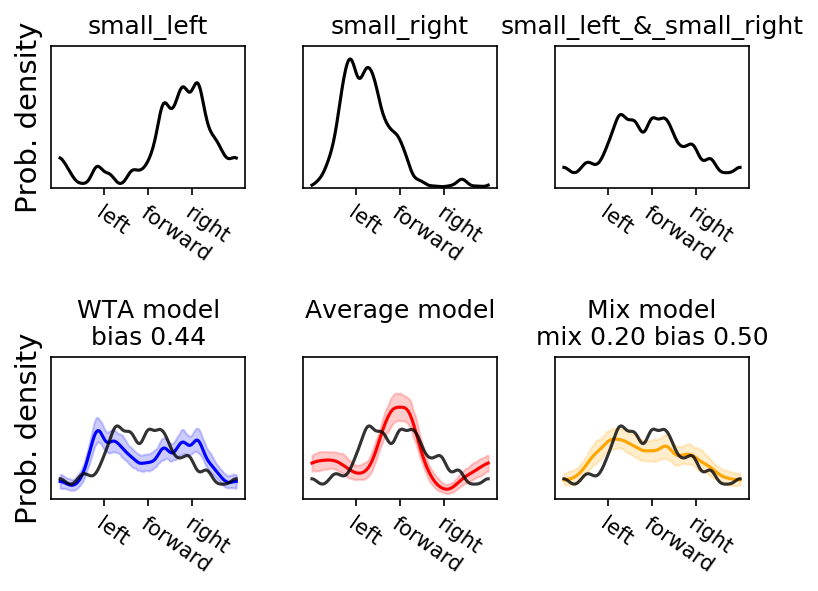

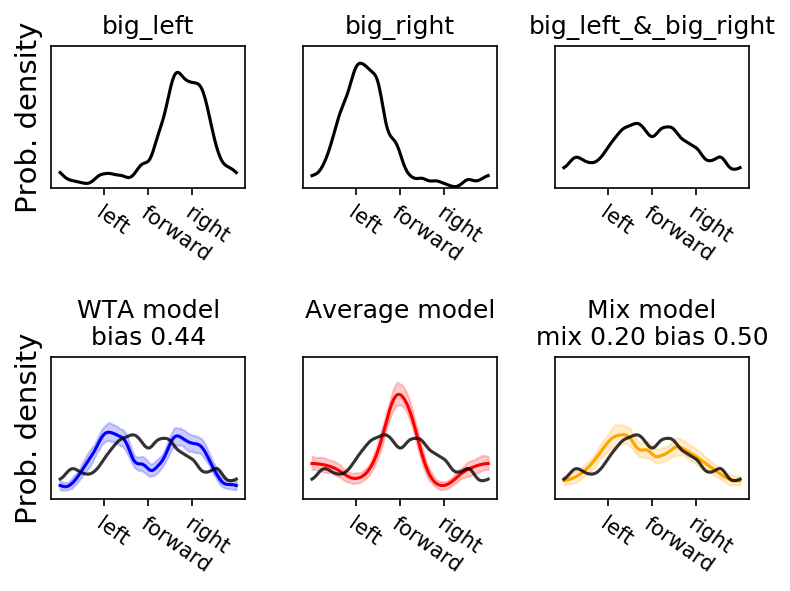

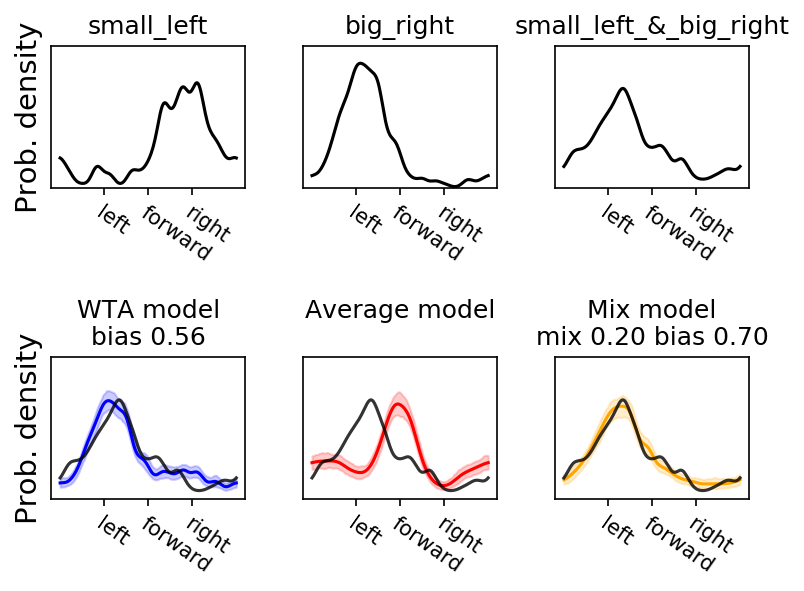

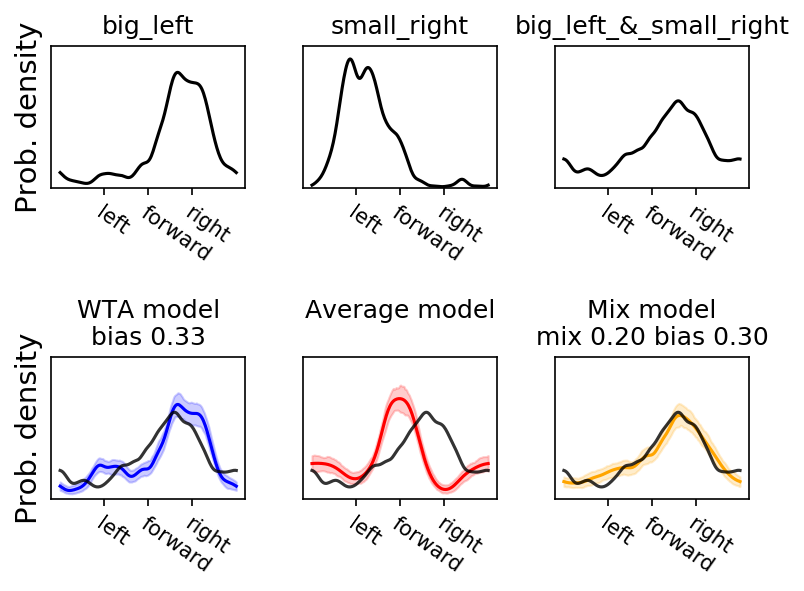

In [18]:
for csnum, cs in enumerate(condition_sets):
    s1, s2, both_all = [all_radians[c] for c in cs]
    #     both_train, both_test = gettesttrain(both_all) #for cross validation
    nreps = 200

    plot_names = [condition_names[cs[0]], condition_names[cs[1]], condition_names[cs[2]],
                  '{} model\nbias {:.2f}'.format(compname, best_compbias_biases[csnum]), 'Average model\n', 'Mix model\nmix {:.2f} bias {:.2f}'.format(*best_biasmix_params[csnum])]
    kdedata = [s1, s2, both_all, np.vstack([mix_model_bias(s1, s2, both_all, 0, best_compbias_biases[csnum]) for i in range(nreps)]),
               np.vstack([avg_model_back(s1, s2, both_all) for i in range(nreps)]),
               np.vstack([mix_model_bias_back(s1, s2, both_all, best_biasmix_params[csnum][0], best_biasmix_params[csnum][1]) for i in range(nreps)]),
               ]
    plotcolors = ['black', 'black', bothcolor, compcolor, avgcolor, mix2color]
    multi_sample = [False, False, False, True, True, True]
    gs = gridspec.GridSpec(2, 3, hspace=1.2, wspace=.3)

    plt.figure(dpi=150)

    for axnum, name in enumerate(plot_names):
        ax = plt.subplot(gs[axnum])

        if multi_sample[axnum]:
            xs, kdes = (zip(*[vonmises_kde(d, 30, 200) for d in kdedata[axnum]]))
            kdes = np.vstack(kdes)
            plt.fill_between(xs[0], np.percentile(kdes, 2.5, 0), np.percentile(kdes, 97.5, 0), alpha=.2, color=plotcolors[axnum])
            plt.plot(xs[0], kdes.mean(0), color=plotcolors[axnum])

            plt.plot(*vonmises_kde(both_all, 30, 200), c=bothcolor, alpha=.8)
        else:
            x, kde = vonmises_kde(kdedata[axnum], 30, 200)
            plt.plot(x, kde, color=plotcolors[axnum])

        plt.title(name)
        plt.ylim((0, .55))
        if axnum % 3 == 0:
            plt.ylabel('Prob. density', fontsize=14)
        plt.xticks([np.pi / 2, np.pi, 3 * np.pi / 2], ['left', 'forward', 'right'], rotation=-35, ha='left', rotation_mode="anchor")
        plt.tick_params(labelleft=False, left=False)
    #plt.savefig('model_figure_export\\' + 'mixbiasmodel_' + condition_names[cs[2]] + '.svg', dpi=300)


# Distributional models -------------------------------
Trying models that use distributions
Does not seem to improve outcomes

# Optimize for best distribution

In [19]:
bestmixes = []
distance_metric = circ_energy_distance_fast
for cs in condition_sets:
    s1, s2, both_all = [all_radians[c] for c in cs]
    both_train, both_test = gettesttrain(both_all)  #for cross validation

    def opt_func(bweight):
        tlen = 200000
        return distance_metric(
            polar_average(np.random.choice(s1, tlen), np.random.choice(s2, tlen), trunc_basis_set(len(bweight), bweight, size=tlen)), both_train)

    nbases = 8
    x0 = np.ones(nbases) * .5
    res = optimize.minimize(opt_func, x0, bounds=optimize.Bounds(0, 10), options={'eps': .1,
                                                                                  'ftol': 1e-1})  
    # method="Nelder-Mead", options={'maxiter':1e4,'maxfev':1e4})#options={'ftol': 1e-6})
    print(res.x)
    bestmixes.append(res.x)


[0.49581296 0.36728518 0.38996682 0.42679975 0.44503365 0.53147973
 0.56571152 0.53836095]
[0.50398956 0.44266826 0.45671752 0.47787257 0.53323503 0.567684
 0.51832064 0.51829674]
[0.412082   0.70693423 0.7795421  0.66132911 0.36445324 0.12064852
 0.0045413  0.        ]
[0.79198659 0.         0.         0.         0.58065825 5.13215516
 5.13215516 5.13215516]


# Plot best distributional mixture models

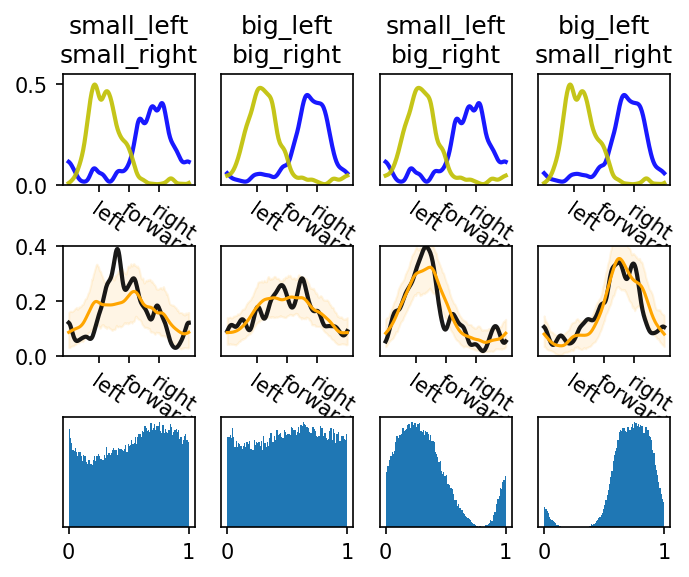

In [20]:
plt.figure(dpi=150)
gs = gridspec.GridSpec(3, len(condition_sets), hspace=.55, right=.8)
for i, cs in enumerate(condition_sets):
    s1, s2, both_all = [all_radians[c] for c in cs]
    both_train, both_test = gettesttrain(both_all)  #for cross validation
    bweights = bestmixes[i]

    plt.subplot(gs[0, i])
    plt.plot(*vonmises_kde(s1, 30, 200), c='b', alpha=.9, label=condition_names[cs[0]], lw=2)
    plt.plot(*vonmises_kde(s2, 30, 200), c='y', alpha=.9, label=condition_names[cs[1]], lw=2)
    plt.ylim((0, .55))
    plt.xticks([np.pi / 2, np.pi, 3 * np.pi / 2], ['left', 'forward', 'right'], rotation=-35, ha='left', rotation_mode="anchor")
    if i > 0:
        plt.tick_params(labelleft=False, left=False)
    plt.title(condition_names[cs[0]] + '\n' + condition_names[cs[1]])

    plt.subplot(gs[1, i])
    plt.plot(*vonmises_kde(both_test, 30, 200), c=bothcolor, alpha=.9, label=condition_names[cs[2]], lw=2)
    tlen = len(both_test)
    xs, kdes = zip(*[vonmises_kde(d, 30, 200) for d in np.vstack([polar_average(np.random.choice(s1, tlen), np.random.choice(s2, tlen),
                                                                                trunc_basis_set(len(bweights), bweights, size=tlen)) for j in
                                                                  range(200)])])
    kdes = np.vstack(kdes)
    plt.fill_between(xs[0], np.percentile(kdes, 2.5, 0), np.percentile(kdes, 97.5, 0), alpha=.1, color=mix2color)
    plt.plot(xs[0], kdes.mean(0), color=mix2color, label='Model')
    plt.ylim((0, .4))
    plt.xticks([np.pi / 2, np.pi, 3 * np.pi / 2], ['left', 'forward', 'right'], rotation=-35, ha='left', rotation_mode="anchor")
    if i > 0:
        plt.tick_params(labelleft=False, left=False)

    plt.subplot(gs[2, i])
    plt.hist(trunc_basis_set(len(bweights), bweights, size=70000), 100)  # TODO norm heights
    plt.tick_params(labelleft=False, left=False)
    #plt.savefig('model_figure_export\\' + 'best distributional mixture models.svg',dpi=300)


# Bar plot for model comparison

In [21]:
cond_num =0 #type condition you want
cond_name=['small_small', 'big_big', 'small_big', 'big_small']
mix_values = [0, 1, best_simple_mix[cond_num]]

s1, s2, both_all = [all_radians[c] for c in condition_sets[cond_num]]
both_train, both_test = gettesttrain(both_all)
n_mix_samples = 5000
stat_dists_mix = np.vstack(
    [[circ_energy_distance_fast(mix_model(s1, s2, both_test, m), both_test) for m in mix_values] for i in range(n_mix_samples)]).T
# stat_dists is npoints by nreps


In [22]:
s1, s2, both_all = [all_radians[c] for c in condition_sets[cond_num]]
both_train, both_test = gettesttrain(both_all)
bweights = bestmixes[cond_num]
stat_dists_mix_dist = np.asarray([circ_energy_distance_fast(polar_average(np.random.choice(s1, tlen), np.random.choice(s2, tlen),
                                                                          trunc_basis_set(len(bweights), bweights, size=tlen)), both_test)
                                  for i in range(n_mix_samples)]).T


In [23]:
stat_dists_mix_combined = np.vstack((stat_dists_mix, stat_dists_mix_dist))
stat_dists_mix_combined.shape

(4, 5000)

# Simple mix model is better than Averaging and WTA alone. Distributional model is not much better than Simple mix

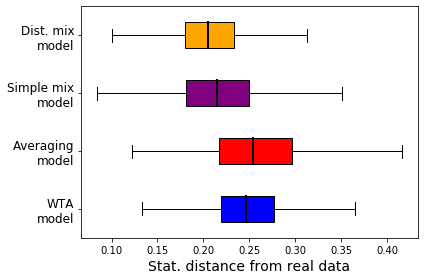

In [24]:
mix_names = ['WTA\nmodel', 'Averaging\nmodel', 'Simple mix\nmodel', 'Dist. mix\nmodel']

#Skip dist model for now
num_to_plot = len(mix_names) 
mix_names = mix_names[:num_to_plot]

mix_colors = [compcolor, avgcolor, mixcolor, mix2color]
meanstat = stat_dists_mix_combined.mean(axis=1)
# lowci = np.percentile(stat_dists_mix_combined, 2.5, axis=1)
# highci = np.percentile(stat_dists_mix_combined, 97.5, axis=1)
# print(meanstat, lowci, highci)

plt.figure()
ax = plt.gca()
x = np.arange(len(mix_names))
# plt.bar(x, meanstat, yerr=np.abs(np.vstack((lowci, highci))-meanstat), color=mix_colors)
bp = plt.boxplot(stat_dists_mix_combined[:num_to_plot, :].T, showfliers=False, patch_artist=True,vert=False)
for patch, color in zip(bp['boxes'], mix_colors):
    patch.set_facecolor(color)
for line, color in zip(bp['medians'], mix_colors):
    line.set_color('black')
    line.set_linewidth(2)

#     for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
#         plt.setp(bp[element], color=edge_color)
# sns.violinplot(data=stat_dists_mix_combined[:, :].T, palette=mix_colors)

plt.xlabel('Stat. distance from real data', fontsize=14)
plt.yticks(x +1 , mix_names, rotation=0, ha='right', rotation_mode="anchor", fontsize=12)


plt.tight_layout()
# plt.savefig('model_figure_export\\' + 'model_comparison_horiz.svg',dpi=300)
